# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    y_train = y_output.values
    y_test = y_test.values

preprocess.x_train.std()

0.99589320646770185

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 122
    lam = 0.001
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
        with tf.variable_scope("Layer_Dense_Hidden"):
            hidden_output = tf.layers.dense(z,latent_dim, activation=tf.nn.relu)

        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(z, classes, activation=tf.nn.softmax)

        with tf.variable_scope("Loss"):
            
            BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat, labels=self.x), reduction_indices=1)
            KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            loss = tf.reduce_mean((BCE + KLD + softmax_loss) * lam)

            #loss = tf.clip_by_value(loss, -1e-2, 1e-2)
            loss = tf.where(tf.is_nan(loss), 1e-2, loss)
            #loss = tf.where(tf.equal(loss, -1e-2), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-2), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = tf.abs(loss, name = "Regularized_loss")
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score'])

    predictions = {}

    results = []
    best_acc = 0
    
    def train(epochs, net, h,f):
        batch_iterations = 200
    
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            Train.best_acc = 0
            for epoch in range(1, (epochs+1)):
                x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                          preprocess.y_train, 
                                                                          test_size=0.2)
                batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                           batch_iterations)
                                                                          
                for i in batch_indices:
                    _, train_loss = sess.run([net.train_op, 
                                                           net.regularized_loss, 
                                                           ], #net.summary_op
                                                          feed_dict={net.x: x_train[i,:], 
                                                                     net.y_: y_train[i,:], 
                                                                     net.keep_prob:1})
                    
                    #summary_writer_train.add_summary(summary_str, epoch)
                    if(train_loss > 1e9):
                        print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                    
                valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], #net.summary_op
                                                          feed_dict={net.x: x_valid, 
                                                                     net.y_: y_valid, 
                                                                     net.keep_prob:1})
                
                test_accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, net.pred, 
                                                                                  net.actual, net.y], #net.summary_op 
                                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                                 net.y_: preprocess.y_test, 
                                                                                 net.keep_prob:1})
                #summary_writer_valid.add_summary(summary_str, epoch)

                if epoch % 1 == 0:
                    print("Step {} | Training Loss: {:.6f} | Test Loss: {:.6f} | Test Accuracy: {:.6f}"
                          .format(epoch, train_loss, test_loss, test_accuracy))

                curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})

                if test_accuracy > Train.best_acc:
                    Train.best_acc = test_accuracy
                    Train.pred_value = pred_value
                    Train.actual_value = actual_value
                    Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)
                    net.saver.save(sess, "dataset/tf_vae_dense_trained_together_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                Train.results.append(Train.result(epochs, f, h,valid_accuracy, test_accuracy))
            print("Best Accuracy on Test data: {}".format(Train.best_acc))
            

In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 16, 32]
    hidden_layers_arr = [2, 4, 6]

    epochs = [50]
    
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f)
        

Current Layer Attributes - epochs:50 hidden layers:2 features count:4
Step 1 | Training Loss: 0.000039 | Test Loss: 0.000141 | Test Accuracy: 0.791164
Step 2 | Training Loss: 0.000032 | Test Loss: 0.000306 | Test Accuracy: 0.801943
Step 3 | Training Loss: 0.000059 | Test Loss: 0.145491 | Test Accuracy: 0.828158
Step 4 | Training Loss: 0.000096 | Test Loss: 0.000229 | Test Accuracy: 0.817734
Step 5 | Training Loss: 0.000059 | Test Loss: 0.000080 | Test Accuracy: 0.838272
Step 6 | Training Loss: 0.000131 | Test Loss: 0.000249 | Test Accuracy: 0.825408
Step 7 | Training Loss: 0.000036 | Test Loss: 0.000223 | Test Accuracy: 0.843994
Step 8 | Training Loss: 0.000057 | Test Loss: 0.000244 | Test Accuracy: 0.838804
Step 9 | Training Loss: 0.000058 | Test Loss: 0.000235 | Test Accuracy: 0.836897
Step 10 | Training Loss: 0.000008 | Test Loss: 0.000218 | Test Accuracy: 0.836098
Step 11 | Training Loss: 0.000043 | Test Loss: 0.000271 | Test Accuracy: 0.829755
Step 12 | Training Loss: 0.000018 | T

Step 49 | Training Loss: 0.000029 | Test Loss: 0.000115 | Test Accuracy: 0.905296
Step 50 | Training Loss: 0.000006 | Test Loss: 0.000113 | Test Accuracy: 0.882984
Best Accuracy on Test data: 0.9074698090553284
Current Layer Attributes - epochs:50 hidden layers:2 features count:16
Step 1 | Training Loss: 0.000108 | Test Loss: 0.000431 | Test Accuracy: 0.814363
Step 2 | Training Loss: 0.000039 | Test Loss: 0.000364 | Test Accuracy: 0.810282
Step 3 | Training Loss: 0.000228 | Test Loss: 0.000391 | Test Accuracy: 0.764461
Step 4 | Training Loss: 0.000082 | Test Loss: 0.000249 | Test Accuracy: 0.798128
Step 5 | Training Loss: 0.000012 | Test Loss: 0.000090 | Test Accuracy: 0.818666
Step 6 | Training Loss: 0.000005 | Test Loss: 0.000137 | Test Accuracy: 0.857612
Step 7 | Training Loss: 0.000057 | Test Loss: 0.000223 | Test Accuracy: 0.854995
Step 8 | Training Loss: 0.000022 | Test Loss: 0.000125 | Test Accuracy: 0.865020
Step 9 | Training Loss: 0.000027 | Test Loss: 0.000134 | Test Accuracy

Step 47 | Training Loss: 0.000022 | Test Loss: 0.000070 | Test Accuracy: 0.866350
Step 48 | Training Loss: 0.000021 | Test Loss: 0.000080 | Test Accuracy: 0.884226
Step 49 | Training Loss: 0.000029 | Test Loss: 0.000134 | Test Accuracy: 0.894384
Step 50 | Training Loss: 0.000072 | Test Loss: 0.000033 | Test Accuracy: 0.891501
Best Accuracy on Test data: 0.8986426591873169
Current Layer Attributes - epochs:50 hidden layers:4 features count:4
Step 1 | Training Loss: 0.000005 | Test Loss: 0.000269 | Test Accuracy: 0.697569
Step 2 | Training Loss: 0.000027 | Test Loss: 0.000721 | Test Accuracy: 0.741838
Step 3 | Training Loss: 0.000217 | Test Loss: 0.000516 | Test Accuracy: 0.707328
Step 4 | Training Loss: 0.000101 | Test Loss: 0.000411 | Test Accuracy: 0.741040
Step 5 | Training Loss: 0.000112 | Test Loss: 0.000360 | Test Accuracy: 0.729640
Step 6 | Training Loss: 0.000048 | Test Loss: 0.000232 | Test Accuracy: 0.758783
Step 7 | Training Loss: 0.000095 | Test Loss: 0.000213 | Test Accurac

Step 45 | Training Loss: 0.000009 | Test Loss: 0.000135 | Test Accuracy: 0.856370
Step 46 | Training Loss: 0.000025 | Test Loss: 0.000172 | Test Accuracy: 0.835300
Step 47 | Training Loss: 0.000043 | Test Loss: 0.000120 | Test Accuracy: 0.839514
Step 48 | Training Loss: 0.000016 | Test Loss: 0.000140 | Test Accuracy: 0.846212
Step 49 | Training Loss: 0.000015 | Test Loss: 0.000152 | Test Accuracy: 0.844349
Step 50 | Training Loss: 0.000009 | Test Loss: 0.000130 | Test Accuracy: 0.848607
Best Accuracy on Test data: 0.8920777440071106
Current Layer Attributes - epochs:50 hidden layers:4 features count:16
Step 1 | Training Loss: 0.000209 | Test Loss: 0.000420 | Test Accuracy: 0.792362
Step 2 | Training Loss: 0.000095 | Test Loss: 0.000276 | Test Accuracy: 0.793559
Step 3 | Training Loss: 0.000043 | Test Loss: 0.000713 | Test Accuracy: 0.862935
Step 4 | Training Loss: 0.000021 | Test Loss: 0.000271 | Test Accuracy: 0.789700
Step 5 | Training Loss: 0.000011 | Test Loss: 0.000134 | Test Accu

Step 43 | Training Loss: 0.000023 | Test Loss: 0.000093 | Test Accuracy: 0.831042
Step 44 | Training Loss: 0.000016 | Test Loss: 0.000112 | Test Accuracy: 0.824565
Step 45 | Training Loss: 0.000005 | Test Loss: 0.000120 | Test Accuracy: 0.832683
Step 46 | Training Loss: 0.000020 | Test Loss: 0.000238 | Test Accuracy: 0.820706
Step 47 | Training Loss: 0.000010 | Test Loss: 0.000205 | Test Accuracy: 0.826872
Step 48 | Training Loss: 0.000062 | Test Loss: 0.000124 | Test Accuracy: 0.851446
Step 49 | Training Loss: 0.000028 | Test Loss: 0.000114 | Test Accuracy: 0.853487
Step 50 | Training Loss: 0.000012 | Test Loss: 0.000061 | Test Accuracy: 0.856104
Best Accuracy on Test data: 0.8561035990715027
Current Layer Attributes - epochs:50 hidden layers:6 features count:4
Step 1 | Training Loss: 0.000086 | Test Loss: 0.000304 | Test Accuracy: 0.724494
Step 2 | Training Loss: 0.000265 | Test Loss: 0.000363 | Test Accuracy: 0.777502
Step 3 | Training Loss: 0.000039 | Test Loss: 0.000144 | Test Acc

Step 40 | Training Loss: 0.000686 | Test Loss: 0.001032 | Test Accuracy: 0.430891
Step 41 | Training Loss: 0.000691 | Test Loss: 0.000962 | Test Accuracy: 0.442734
Step 42 | Training Loss: 0.000646 | Test Loss: 0.001010 | Test Accuracy: 0.430846
Step 43 | Training Loss: 0.000676 | Test Loss: 0.001021 | Test Accuracy: 0.432266
Step 44 | Training Loss: 0.000653 | Test Loss: 0.001086 | Test Accuracy: 0.430403
Step 45 | Training Loss: 0.000583 | Test Loss: 0.001072 | Test Accuracy: 0.430891
Step 46 | Training Loss: 0.000740 | Test Loss: 0.001058 | Test Accuracy: 0.430758
Step 47 | Training Loss: 0.000640 | Test Loss: 0.001021 | Test Accuracy: 0.436347
Step 48 | Training Loss: 0.000670 | Test Loss: 0.001033 | Test Accuracy: 0.430802
Step 49 | Training Loss: 0.000703 | Test Loss: 0.001072 | Test Accuracy: 0.433996
Step 50 | Training Loss: 0.000710 | Test Loss: 0.001109 | Test Accuracy: 0.433996
Best Accuracy on Test data: 0.8425745368003845
Current Layer Attributes - epochs:50 hidden layers:

Step 37 | Training Loss: 0.000783 | Test Loss: 0.001175 | Test Accuracy: 0.440073
Step 38 | Training Loss: 0.000931 | Test Loss: 0.001122 | Test Accuracy: 0.435504
Step 39 | Training Loss: 0.000850 | Test Loss: 0.001149 | Test Accuracy: 0.434839
Step 40 | Training Loss: 0.000612 | Test Loss: 0.001278 | Test Accuracy: 0.468950
Step 41 | Training Loss: 0.000599 | Test Loss: 0.001097 | Test Accuracy: 0.457106
Step 42 | Training Loss: 0.000746 | Test Loss: 0.001111 | Test Accuracy: 0.452715
Step 43 | Training Loss: 0.000733 | Test Loss: 0.001115 | Test Accuracy: 0.437367
Step 44 | Training Loss: 0.000735 | Test Loss: 0.001209 | Test Accuracy: 0.447880
Step 45 | Training Loss: 0.000784 | Test Loss: 0.001193 | Test Accuracy: 0.439319
Step 46 | Training Loss: 0.000651 | Test Loss: 0.001075 | Test Accuracy: 0.439629
Step 47 | Training Loss: 0.000635 | Test Loss: 0.001081 | Test Accuracy: 0.440339
Step 48 | Training Loss: 0.000695 | Test Loss: 0.001065 | Test Accuracy: 0.439141
Step 49 | Traini

In [10]:
df_results = pd.DataFrame(Train.results)

In [11]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score
97,50,8,2,0.913118,0.907470
98,50,8,2,0.914031,0.905296
143,50,16,2,0.891248,0.904587
144,50,16,2,0.881484,0.903123
145,50,16,2,0.888272,0.901925
165,50,32,2,0.888391,0.898643
191,50,32,2,0.889780,0.897312
111,50,16,2,0.894781,0.896292
96,50,8,2,0.915340,0.895227
198,50,32,2,0.851201,0.894384


In [12]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_scores.pkl")

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.8446  0.1554]
 [ 0.0916  0.9084]]


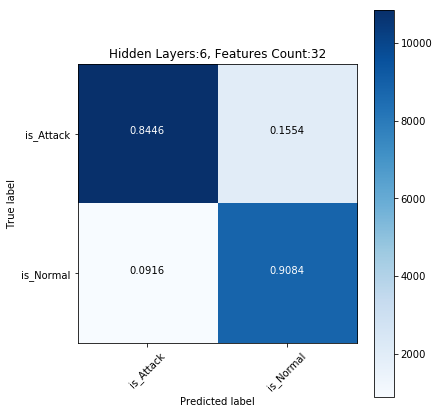

In [14]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)